In [8]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math

# 4. High-Time Resolution Failing of the LN Model

In [9]:
# 1. load the data
d = loadmat('LGN_FFdata.mat')

spiks = d['FFspks'][0].flatten() # number is number of seconds from the start for that spike
stims = d['FFstim'].flatten() # the stimlus value at the time step
dt = d['DTstim'][0].flatten() # time between each stimulus

In [10]:
# 1a. scale the spiks by 8, in order to use 1/8 the stimulus resolution
stims8 = np.array([[stim]*8 for stim in stims]).flatten()
dt8 = dt / 8.

In [58]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims, dt):
    max_stim = len(stims) * dt
    # put a tiny amount of extra time at the end of the bin to make sure that we include the extreme times
    epsilon = dt / 2
    return np.histogram(spiks, bins=np.arange(0, max_stim+epsilon, dt), range=(0, max_stim))[0]


# combine the spiks and stims by as columns
def merge_spiks_and_stims(spiks, stims, dt):
    spiks_per_stim = associate_spiks_to_stims(spiks, stims, dt)
    return np.column_stack([stims.flatten(), spiks_per_stim])


# shifts vector by the amount (shift can be positive or negative)
# fills the empty elements with zeros
def shift_vector(vector, shift):
    if shift > len(vector):
        shift = len(vector)
    elif shift < 0 and abs(shift) > len(vector):
        shift = -len(vector)
    
    if shift > 0:
        shifted = np.concatenate((np.zeros((shift)), vector[:-shift]), axis=None)
    elif shift < 0:
        shifted = np.concatenate((vector[abs(shift):], np.zeros((abs(shift)))), axis=None)
    else:
        shifted = vector
    
    return shifted


def calc_sta(merged, num_lags):
    sta = []
    for lag in range(0, num_lags):
        lagged_stim = shift_vector(merged[:,0], lag)
        sta.append(np.sum(lagged_stim * merged[:,1]) / np.sum(merged[:,1]))
    sta = np.array(sta)
    return sta


def g_convolve(s, k):
    # pad to make causal
    k2 = np.zeros(len(k)*2-1)
    k2[len(k)-1:] = [i for i in k]
    g = np.convolve( s, k2, mode='same')
    return g 

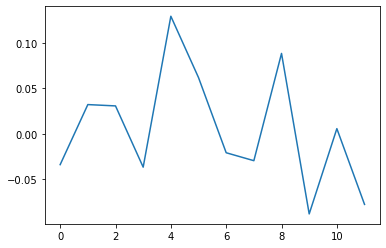

In [60]:
# 2. calculate the STA for the neuron --> g()

merged = merge_spiks_and_stims(spiks, stims, dt8)

sta = calc_sta(merged, num_lags=12)
plt.plot(sta)

In [61]:
# 3. calculate the spiking nonlinearity function --> r()
g = g_convolve(stims, sta)

# normalize g by the std dev of g and then recompute the filter responses over the stimulus
g = sta / np.std(filtered_stims)
g = g_convolve(stims, g)

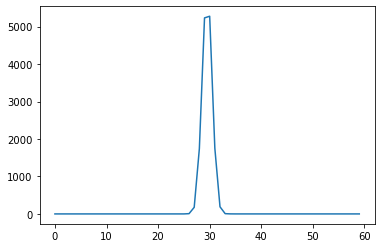

In [62]:
histg = np.histogram(g, bins=np.arange(-6, 6.2, 0.2))[0]
plt.plot(histg)

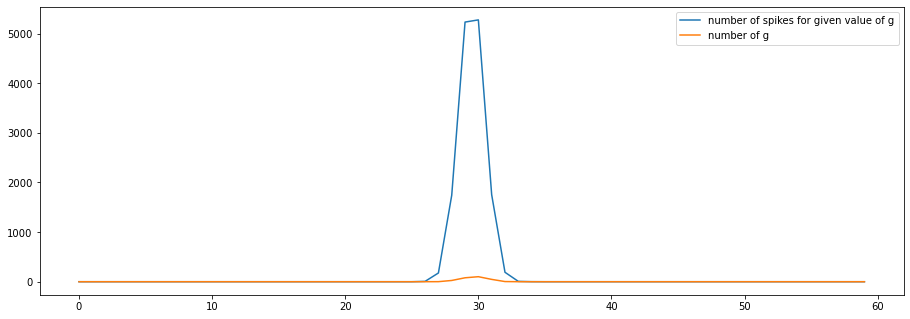

In [63]:
# filter the filtered_stims for just when there is a spike
indices_when_spiking = (merged[:,1] > 0).nonzero()[0]

# NOTE: this is wrong, we don't just want g(stim) when there is a spike,
#       we want to multiply the value of g by the number of spikes
filtered_stims_when_spiking = g[indices_when_spiking]
histg_spiking = np.histogram(filtered_stims_when_spiking, bins=np.arange(-6, 6.2, 0.2))[0]

axc = plt.axes([1, 1, 2, 1])
axc.plot(histg, label='number of spikes for given value of g')
axc.plot(histg_spiking, label='number of g')
axc.legend()
plt.show()

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_12451/1732704737.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(histg_spiking / histg)


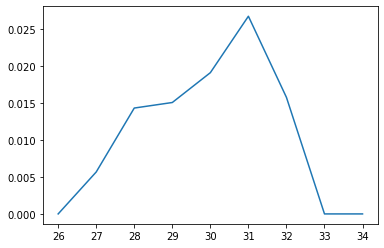

In [64]:
plt.plot(histg_spiking / histg)

In [65]:
# 4. predict the rate from the cascade model r(g(stim))

In [66]:
# the stims are the same for each trial
stimsr = d['FFstimR'][:,0]

In [67]:
# split the trials into rows, using -1 as the flag variable
spiksr = []
spikr = []
for x in d['FFspksR'][0]:
    if x == -1:
        spiksr.append(np.array(spikr))
        spikr = []
        continue
    spikr.append(x)

In [69]:
# merge the stimsr and spiksr for each trial
mergedrs = []
for spiks in spiksr:
    mergedrs.append(merge_spiks_and_stims(spiks, stimsr, dt8))
mergedrs = np.array(mergedrs)

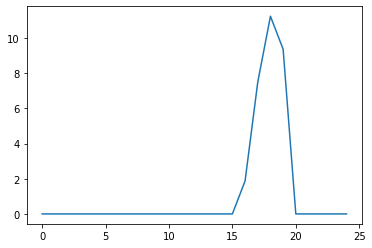

In [70]:
# calculate the neurons firing rate as a function of time, using a bin size DTstim
# r(t) = n_spk(t) / dt
# sum over the columns and divide by dt
rate_t = [np.mean(mergedr) for mergedr in mergedrs[:,:,1].T] / dt
# plot the firing rate between 800ms and 1000ms, vertical axis units in Hz
plt.plot(rate_t[math.floor(.8/dt):math.ceil(1/dt)])

In [71]:
# 3. calculate the spiking nonlinearity function --> r()
g = g_convolve(stimsr, sta)

# normalize g by the std dev of g and then recompute the filter responses over the stimulus
g = sta / np.std(g)
g = g_convolve(stimsr, g)
filtered_stimsr = g

In [72]:
nl = histg_spiking / histg
nl = np.array(list(map(lambda x: x if not np.isnan(x) else 0, nl))) # remove the NaNs from nl

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_12451/1895170736.py:1: RuntimeWarning: invalid value encountered in true_divide
  nl = histg_spiking / histg


In [73]:
def nl_func(g_stim):
    x = np.arange(-6, 6, 0.2)
    # find the closest nl value for the given g_stim
    for i in range(len(x)-1):
        if g_stim >= x[i] and g_stim < x[i+1]:
            return nl[i]
    return -1

97.4324532246364


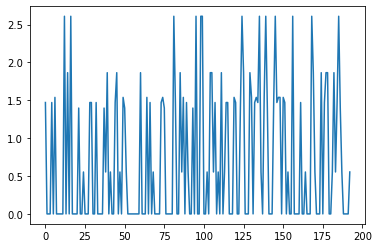

In [74]:
# get the probability of a spike at each stimulus presentation
pred_prob_t = np.array(list(map(nl_func, filtered_stimsr)))

# multiply this by the max number of spikes to change this to Hz
max_num_spikes = np.max(rate_t)
print(max_num_spikes)

pred_t = pred_prob_t * max_num_spikes

# plot it
plt.plot(pred_t[math.floor(.8/dt8):math.ceil(1/dt8)])

In [75]:
r2 = 1 - (np.var(rate_t - pred_t) / np.var(rate_t))
r2

-0.011045708377837693